In [8]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
from matplotlib import pyplot as plt

ADF Statistic: -3.4141054679471807
p-value: 0.01048731342021607


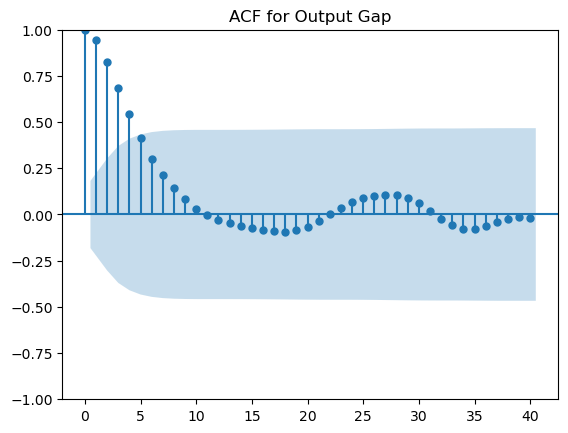

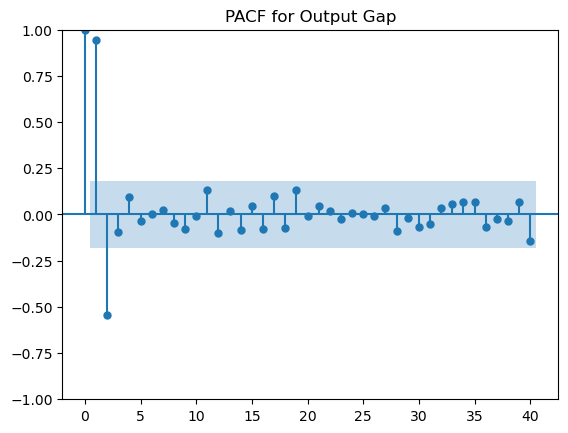

In [10]:
# Load the data
# Make sure to replace 'your_file_path.xlsx' with the actual path to your Excel file after uploading it
data = pd.read_excel("C:/Users/HHGiang/Documents/KEIO/3S/33 IntMacro1B/shortrun output gap.xlsx")


# Split the data into in-sample and out-of-sample
split_point = int(len(data) * 0.7)
in_sample_data = data[:split_point]
out_of_sample_data = data[split_point:]

# Check if the data is stationary
adf_result = adfuller(in_sample_data['Output gap'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Plot ACF and PACF
plot_acf(in_sample_data['Output gap'], lags=40)
plt.title('ACF for Output Gap')
plt.show()

plot_pacf(in_sample_data['Output gap'], lags=40, method='ywm')
plt.title('PACF for Output Gap')
plt.show()

In [11]:
# Fit various ARIMA models and compare their AIC, BIC, HQIC
p = d = q = range(0, 3)  # Example range, can be adjusted
pdq_combinations = list(itertools.product(p, d, q))

warnings.filterwarnings("ignore")  # specify to ignore warning messages
best_aic = float('inf')
best_bic = float('inf')
best_hqic = float('inf')
best_order = None

results = []

for combination in pdq_combinations:
    try:
        model = ARIMA(in_sample_data['Output gap'], order=combination)
        results.append(model.fit())
    except:
        continue

# Extract the AIC, BIC, and HQIC from each model and find the best ones
results_df = pd.DataFrame({
    'order': pdq_combinations,
    'AIC': [result.aic for result in results],
    'BIC': [result.bic for result in results],
    'HQIC': [result.hqic for result in results]
})

# Find the best models according to each criterion
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]
best_hqic_model = results_df.loc[results_df['HQIC'].idxmin()]

print(f"Best AIC Model: {best_aic_model}")
print(f"Best BIC Model: {best_bic_model}")
print(f"Best HQIC Model: {best_hqic_model}")

# You can then fit the best model according to AIC, BIC, or HQIC
# For example, using the best AIC model:
best_order = best_aic_model['order']
best_model = ARIMA(in_sample_data['Output gap'], order=best_order)
best_model_fit = best_model.fit()
print(best_model_fit.summary())

Best AIC Model: order     (2, 0, 0)
AIC       174.85177
BIC      185.866131
HQIC     179.322971
Name: 18, dtype: object
Best BIC Model: order     (1, 1, 0)
AIC      178.591847
BIC      184.081711
HQIC     180.820156
Name: 12, dtype: object
Best HQIC Model: order     (2, 0, 0)
AIC       174.85177
BIC      185.866131
HQIC     179.322971
Name: 18, dtype: object
                               SARIMAX Results                                
Dep. Variable:             Output gap   No. Observations:                  116
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -83.426
Date:                Tue, 16 Apr 2024   AIC                            174.852
Time:                        11:42:46   BIC                            185.866
Sample:                             0   HQIC                           179.323
                                - 116                                         
Covariance Type:                  opg                                         
       

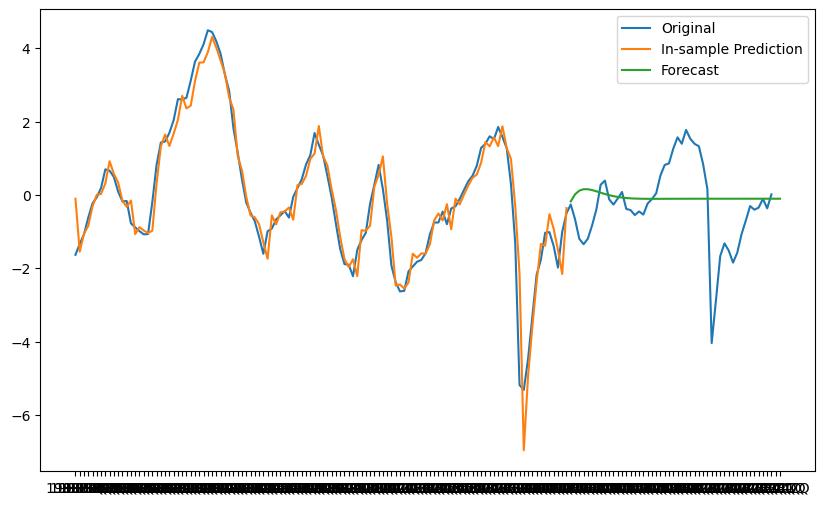

KeyError: 0

In [14]:
# In-sample prediction
in_sample_pred = best_model_fit.predict(start=in_sample_data.index[0], end=in_sample_data.index[-1], typ='levels')

# Out-of-sample forecast
forecast = best_model_fit.forecast(steps=len(out_of_sample_data))

# Plot the predictions and the forecast
plt.figure(figsize=(10,6))
plt.plot(data['Quarterly'], data['Output gap'], label='Original')
plt.plot(in_sample_data['Quarterly'], in_sample_pred, label='In-sample Prediction')
plt.plot(out_of_sample_data['Quarterly'], forecast, label='Forecast')
plt.legend()
plt.show()

# Forecast beyond the dataset for 2024 Q1 and Q2
future_forecast = best_model_fit.forecast(steps=2)
print(f"Forecast for 2024 Q1: {future_forecast[0]}")
print(f"Forecast for 2024 Q2: {future_forecast[1]}")

# Save the full data with forecast to CSV
full_data_with_forecast = data.copy()
future_dates = [pd.Timestamp('2024-01-01'), pd.Timestamp('2024-04-01')]
future_forecast_df = pd.DataFrame({'Quarterly': future_dates, 'Output gap': future_forecast})
full_data_with_forecast = pd.concat([full_data_with_forecast, future_forecast_df])
full_data_with_forecast.to_csv('/mnt/data/output_gap_forecast.csv', index=False)

In [15]:
# In-sample prediction
in_sample_pred = best_model_fit.predict(start=in_sample_data.index[0], end=in_sample_data.index[-1], typ='levels')

# Out-of-sample forecast - align the forecast index with the out_of_sample_data index
forecast_index = pd.date_range(start=out_of_sample_data['Quarterly'].iloc[0], periods=len(out_of_sample_data), freq='Q')
forecast = pd.Series(best_model_fit.forecast(steps=len(out_of_sample_data)), index=forecast_index)

# Plot the predictions and the forecast
plt.figure(figsize=(10,6))
plt.plot(data['Quarterly'].astype(str), data['Output gap'], label='Original')  # Convert period to string for plotting
plt.plot(in_sample_data['Quarterly'].astype(str), in_sample_pred, label='In-sample Prediction')  # Convert period to string for plotting
plt.plot(forecast_index.astype(str), forecast, label='Forecast')  # Convert period to string for plotting
plt.legend()
plt.show()

# Forecast beyond the dataset for 2024 Q1 and Q2 - ensure the index is appropriate for the forecast
future_forecast = best_model_fit.forecast(steps=2)
future_forecast_index = pd.date_range(start=data['Quarterly'].iloc[-1] + 1, periods=2, freq='Q')
print(f"Forecast for 2024 Q1: {future_forecast.iloc[0]}")
print(f"Forecast for 2024 Q2: {future_forecast.iloc[1]}")

# Save the full data with forecast to CSV - correctly handle PeriodIndex and future dates
full_data_with_forecast = data.copy()
full_data_with_forecast = full_data_with_forecast.append(pd.DataFrame({
    'Quarterly': future_forecast_index,
    'Output gap': future_forecast.values
}), ignore_index=True)
full_data_with_forecast['Quarterly'] = full_data_with_forecast['Quarterly'].dt.to_period('Q')  # Convert Timestamp to Period
full_data_with_forecast.to_csv('/mnt/data/output_gap_forecast.csv', index=False)


DateParseError: Unknown datetime string format, unable to parse: 2012.1Q